In [11]:
import pickle
import pandas as pd
from google.cloud import bigquery
from google.cloud import storage
import random

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from params import *
from utilities import *

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [40]:
# Cliente de Bigquery
client_storage = storage.Client()

# Parametro para samplear o no los datos de entrenamiento
sample = True

# Parametro para crear clusters en los datos de entrenamiento
cluster = False

## Carga de datos entrenamiento

In [3]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = True)
data = prepare_data(data_original)

data.head(5)

Leyendo datos de la tabla: diabetes


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,0.0,54.0,0.0,54001.0,1.0,0.0,57.6,1.5,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,0.0,69.0,0.0,15001.0,2.0,0.0,57.6,1.5,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,0.0,57.0,0.0,8001.0,3.0,0.0,57.6,1.5,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,1.0
4,0.0,50.0,0.0,19001.0,4.0,0.0,57.6,1.5,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


## Clusters

In [24]:
## Funciones para crear clusters

def peso_edad(value):
    if value < 45:
        return 0
    elif value < 54:
        return 1
    elif value <= 64:
        return 2
    else:
        return 3

def peso_imc(value):
    if value < 30:
        return 0
    elif value < 35:
        return 1
    elif value < 40:
        return 2
    else:
        return 3

def peso_pa(value, gender):

    if gender == 0:
        if value < 90:
            return 0
        elif value < 95:
            return 1
        else:
            return 2
    else:
        if value < 94:
            return 0
        elif value < 100:
            return 1
        else:
            return 2

def peso_ejercicio(value):
    if value == 2:
        return 2
    else:
        return 0

def peso_var_bivalente(value):
    if value == 1:
        return 2
    else:
        return 0

def peso_HDL(value):
    if value < 40:
        return 2
    elif value < 60:
        return 1
    else:
        return 0

def peso_LDL(value):
    if value < 130:
        return 0
    elif value < 160:
        return 1
    elif value < 190:
        return 2
    else:
        return 3

def peso_trigliceridos(value):
    if value < 150:
        return 0
    elif value < 200:
        return 1
    elif value < 500:
        return 2
    else:
        return 3

    
## Diccionario con las columnas y su respectiva funcion de cluster
dict_variables = {
    'edad' : peso_edad,
    'imc' : peso_imc,
    'PERIMETRO_ABDOMINAL' : peso_pa,
    'hace_ejercicio' : peso_ejercicio,
    'med_hipertension' : peso_var_bivalente,
    'familiar_dm' : peso_var_bivalente,
    'HDL' : peso_HDL,
    'LDL' : peso_LDL,
    'trigliceridos' : peso_trigliceridos,
    'ant_cardiovascular' : peso_var_bivalente,
    'dm_gestacional' : peso_var_bivalente,
}

In [30]:
df_cluster = pd.DataFrame()

if cluster:
    print('Se crearan clusters para las variables')
    print(list(dict_variables.keys()))
    for genero in [0,1]:
        print(f'Creando clusters para el genero: {genero}')
        data_temp = data[data.genero == genero].copy()
        for key in dict_variables:
            if key == 'PERIMETRO_ABDOMINAL':
                data_temp[key] = data_temp[key].map(lambda x: dict_variables[key](x, genero))
            else:
                data_temp[key] = data_temp[key].map(lambda x: dict_variables[key](x))
        df_cluster = pd.concat([df_cluster,data_temp])
        
df_cluster.head(5)

Se crearan clusters para las variables
['edad', 'imc', 'PERIMETRO_ABDOMINAL', 'hace_ejercicio', 'med_hipertension', 'familiar_dm', 'HDL', 'LDL', 'trigliceridos', 'ant_cardiovascular', 'dm_gestacional']
Creando clusters para el genero: 0
Creando clusters para el genero: 1


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,2,0.0,11001.0,0.0,0.0,57.6,1.5,0,1,0,0,0,0,0,0,0,2,0.0
1,0.0,2,0.0,54001.0,1.0,0.0,57.6,1.5,0,1,0,2,0,0,0,0,0,2,0.0
2,0.0,3,0.0,15001.0,2.0,0.0,57.6,1.5,0,0,2,0,0,0,0,0,0,0,0.0
3,0.0,2,0.0,8001.0,3.0,0.0,57.6,1.5,0,2,1,2,0,0,0,0,2,2,1.0
4,0.0,1,0.0,19001.0,4.0,0.0,57.6,1.5,0,1,1,1,0,0,0,0,0,2,0.0


## Ajustes Modelo

In [34]:
# Conjunto de variables a usar en el entrenamiento

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal', # Mirar
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente', # Mirar
                      'raza_paciente', # Mirar
                      'diabetes']

In [41]:
## Consolidacion de los datos de entrenamiento

# Se define si se trabaja con clusters o sin ellos
if cluster:
    df_to_begin = df_cluster
else:
    df_to_begin = data.copy()

# Sampleo de los datos para igualar la cantidad de pacientes con y sin diabetes
if sample:
    df = df_to_begin[df_to_begin.diabetes == 1]
    df_sample = df_to_begin[df_to_begin.diabetes == 0].sample(len(df))
    df = pd.concat([df,df_sample]).dropna()
else:
    df = df_to_begin

# Filtrar DataFrame con las variables a entrenar
df_to_train = df[variables_to_train].copy()
df_to_train.head(5)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0,1.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0,1.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0,1.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0,1.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0,1.0


In [42]:
## Entrenamiento del modelo

# Definir X e y para entrenar el modelo
X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

# Segmentar la data en conjuntos de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Creacion del modelo
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 20, bootstrap = True)

# Entrenar el modelo
model.fit(X_train, y_train)

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0


RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200)

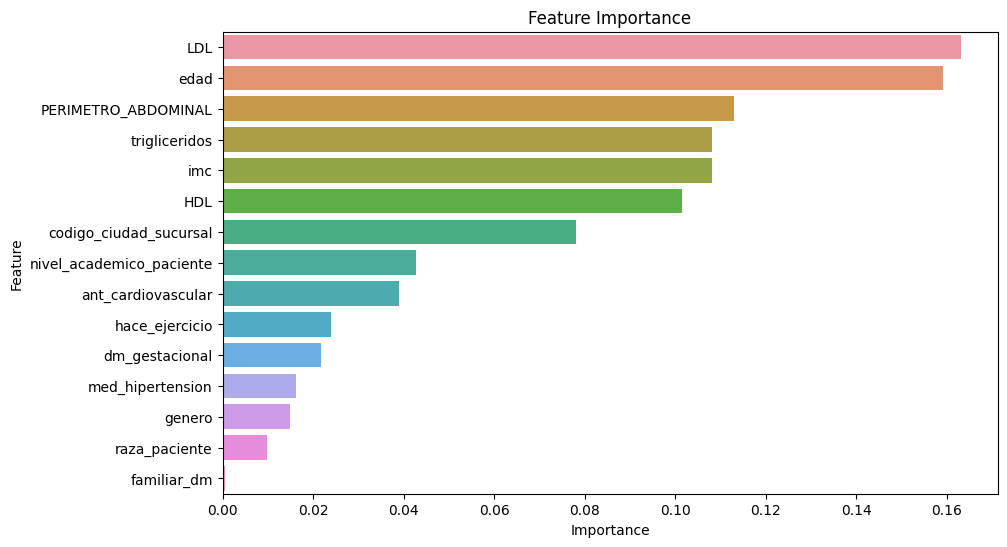

In [43]:
## Variables mas relevantes en el entrenamiento del modelo

# Creacion de dataframe con las columnas y el nivel de importancia de las variables
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [46]:
## Validacion del modelo usando las metricas de acuraccy, f1-score y la matriz de confusion

# Valores predichos
y_pred = model.predict(X_test)

# Calculo de metricas
metrica = round(model.score(X_test, y_test)*100,2)
f1 = round(f1_score(y_test, y_pred)*100,2)
matriz_confusion = pd.DataFrame(confusion_matrix(y_test, y_pred))
matriz_confusion.columns = ['Negativo','Positivo']
matriz_confusion.index = ['Negativo','Positivo']

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(matriz_confusion)

Modelo entrenado con una precision de: 69.9
Modelo entrenado con f1 de: 71.04
La matriz de confusion es:


,Negativo,Positivo
Negativo,19199,10009
Positivo,7513,21495


In [45]:
## Validar casos particulares

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 62.18%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
77913,0.0,55.0,0.0,70001.0,3.0,0.0,101.0,1.68,35.785147,38.4,75.7,120.0,1.0,0.0,1.0,0.0,114.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 33.86%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
139579,0.0,77.0,0.0,70001.0,1.0,0.0,36.0,1.44,17.361111,66.0,146.0,95.0,1.0,0.0,1.0,0.0,59.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 59.14%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
140669,0.0,60.0,1.0,25307.0,0.0,0.0,84.0,1.7,29.065744,31.0,76.0,247.0,1.0,0.0,1.0,0.0,88.0,0.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 78.35%
La prediccion (en categoria) de tener diabetes es de: 1.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
286147,0.0,74.0,1.0,76001.0,0.0,0.0,80.7,1.62,30.749886,28.0,67.0,160.0,1.0,0.0,1.0,0.0,115.0,3.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 3.62%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
66355,0.0,28.0,0.0,19001.0,0.0,0.0,66.0,1.61,25.461981,44.0,127.2,94.0,0.0,0.0,0.0,0.0,83.0,1.0,0.0
